# 0. Import neccesary libraries

In [1]:
import os
import shutil
import torch
from torch.utils.data import Dataset
import wave
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram
from torchaudio import load

# 1. Visualize the dataset

In [18]:
class MUSDB18Spectrogram:
    """
    Class to compute and visualize spectrograms of audio files.
    
    Args:
        wav_file_path (str): Path to the WAV file.
        
    Attributes:
        wav_file_path (str): Path to the WAV file.
        audio_name (str): Name of the audio file extracted from the path.
        signal (np.ndarray): Audio signal loaded from the WAV file.
        sample_rate (int): Sample rate of the audio signal.
        f (np.ndarray): Frequency bins of the spectrogram.
        t (np.ndarray): Time bins of the spectrogram.
        spectrogram (np.ndarray): Computed spectrogram of the audio signal.
    """
    def __init__(self, wav_file_path: str):
        """
        Initializes the MUSDB18Spectrogram object.
        """
        self.wav_file_path = wav_file_path
        self.audio_name = os.path.basename(os.path.dirname(self.wav_file_path))

        with wave.open(self.wav_file_path, 'rb') as audio_file:
            # Read audio data
            self.signal = np.frombuffer(audio_file.readframes(-1), dtype=np.int16)
            self.sample_rate = audio_file.getframerate()

        # Compute the spectrogram for the segment
        self.f, self.t, self.spectrogram = spectrogram(x=self.signal, fs=self.sample_rate)
        self.spectrogram_decibels = np.log(self.spectrogram)

    def __str__(self):
        """
        Returns a string representation of the object.
        """
        return f'Spectrogram object of audio {self.audio_name}'

    def visualize(self):
        # Plot the spectrogram
        fig, axes = plt.subplots(1,1, figsize=(15, 10))

        # Plot the regular spectrogram
       
        #im1 = axes.pcolormesh(self.t, self.f, 10 * np.log10(self.spectrogram), cmap='inferno')  # Applying log scale for better visualization
        im1 = axes.pcolormesh(self.t, self.f, self.spectrogram_decibels, cmap='inferno')  # Applying log scale for better visualization
        axes.set_ylabel('Frequency (Hz)')
        axes.set_xlabel('Time (s)')
        axes.set_title(f'Spectrogram of {self.audio_name}')
        plt.colorbar(im1, ax=axes, label='Intensity (dB)')  # Add colorbar to the first subplot

    def get_tensor(self, decibels: bool=False):
        """
        Converts the spectrogram to a PyTorch tensor.

        Returns:
            torch.Tensor: Spectrogram tensor.
        """
        return torch.tensor(self.spectrogram_decibels) if decibels else torch.tensor(self.spectrogram)
    
    def save_spectrogram(self):
        pass

/var/folders/vw/fdrl_85534sdc5svv3301tsw0000gn/T/ipykernel_18689/1185332528.py:31: RuntimeWarning: divide by zero encountered in log
  self.spectrogram_decibels = np.log(self.spectrogram)


Spectrogram object of audio Am Contra - Heart Peripheral


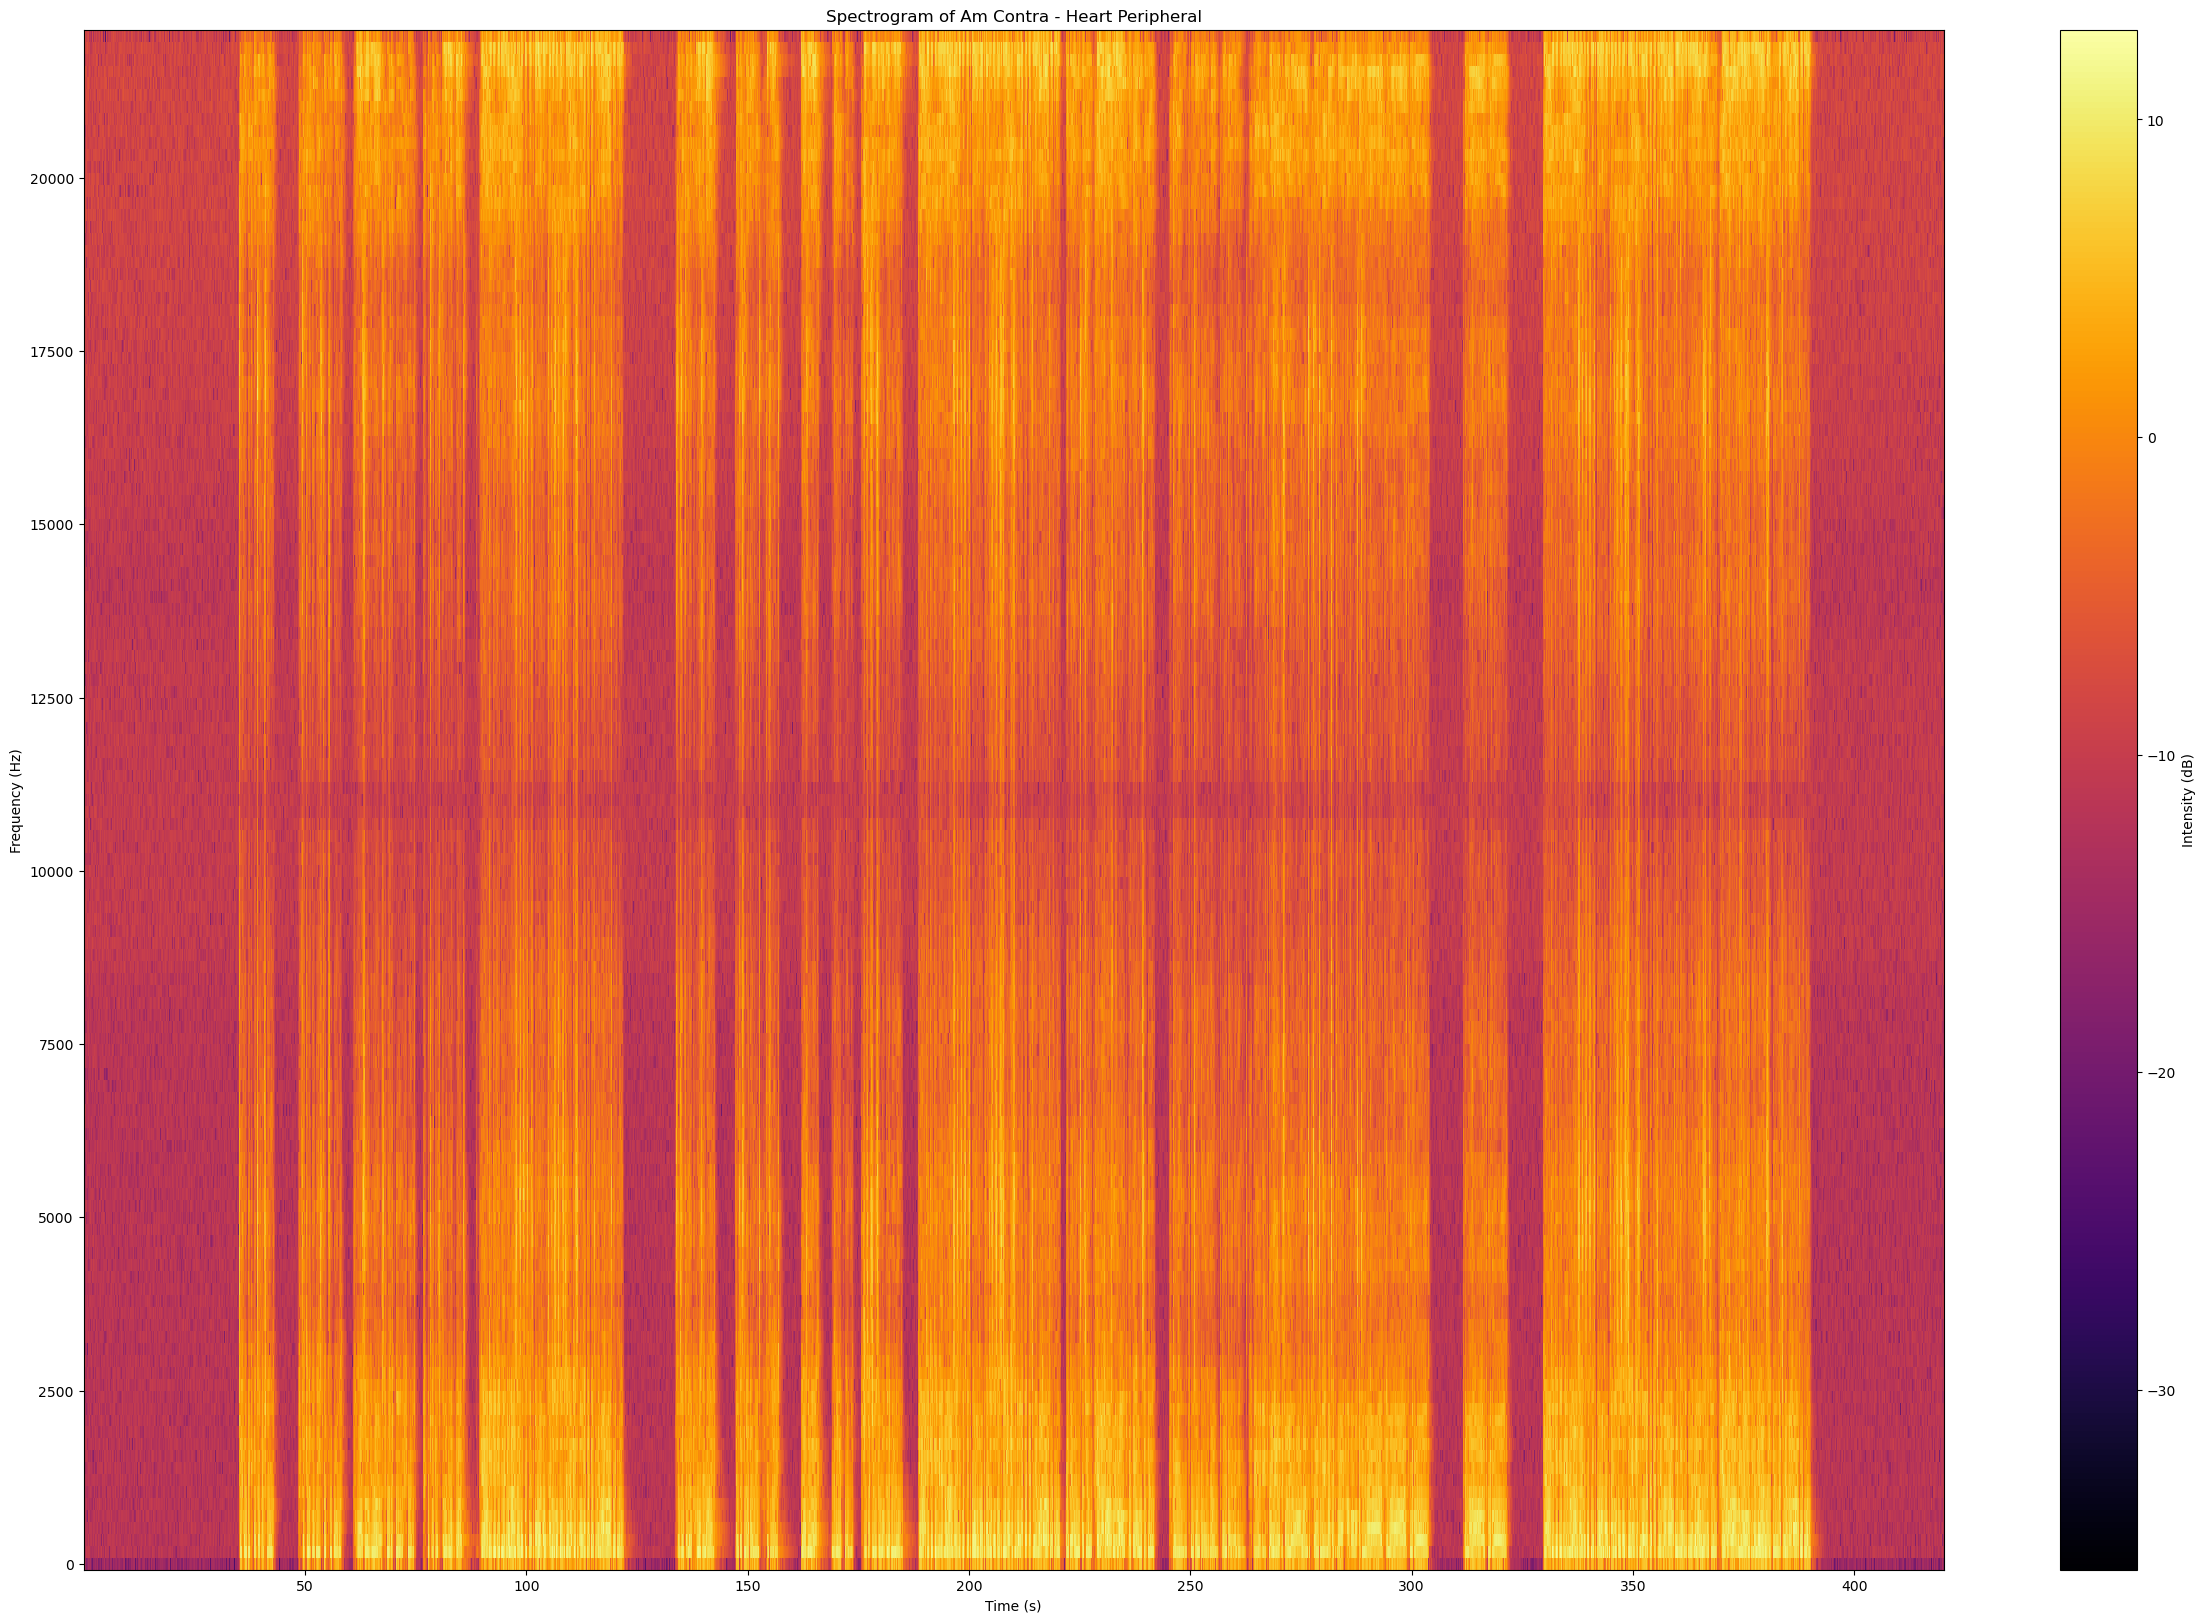

In [29]:

audio_file_path_mix = './music_data/musdb18hq/test/Am Contra - Heart Peripheral/vocals.wav'
my_spectrogram = MUSDB18Spectrogram(audio_file_path_mix)
print(a)

my_spectrogram.visualize()

my_spectrogram.sample_rate

tensor = my_spectrogram.get_tensor()

torch.save(tensor, './music_data/musdb18hq/test.pt')

# 2. Loading the data and preprocessing

In [2]:
#  We will create a class that inherits from Dataset

class MUSDB18Dataset(Dataset):

    def __init__(self, path_to_song_library: str):
        pass

    def __getitem__(self, index):
        pass
        



# Source folder path
source_folder = './music_data/musdb18hq/test'

# Destination folder path
destination_folder = './music_data/musdb18hq_numbered/test'

# Iterate through directories in the source folder
for idx, dirname in enumerate(os.listdir(source_folder)):
    # Get the full path of the current directory
    source_dir_path = os.path.join(source_folder, dirname)
    
    # Check if it's a directory
    if os.path.isdir(source_dir_path):
        # Generate new directory name with leading zeros
        new_dirname = f'{str(idx+1).zfill(4)}'
        
        # Destination directory path
        destination_dir_path = os.path.join(destination_folder, new_dirname)
        
        # Copy the directory to the destination folder and rename it
        shutil.copytree(source_dir_path, destination_dir_path)
        
        print(f'Copied {dirname} to {new_dirname}')
    else:
        print(f'Skipped {dirname} (it is not a directory)')
        

FileExistsError: [Errno 17] File exists: './music_data/musdb18hq_numbered/test/0001'

In [14]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset

class CustomAudioDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform

        self.samples = []
        subfolders = [f for f in os.listdir(root_folder) if not f.startswith('.DS_Store')]
        for subfolder in subfolders:
            mixture_path = os.path.join(root_folder, subfolder, 'mixture.wav')
            vocals_path = os.path.join(root_folder, subfolder, 'vocals.wav')
            mixture_waveform, _ = torchaudio.load(mixture_path, normalize=True)
            vocals_waveform, _ = torchaudio.load(vocals_path, normalize=True)

            # Compute spectrograms
            mixture_spectrogram = self.compute_spectrogram(mixture_waveform)
            vocals_spectrogram = self.compute_spectrogram(vocals_waveform)

            # Pad both spectrograms to match the dimensions of the larger one
            max_freq = max(mixture_spectrogram.shape[1], vocals_spectrogram.shape[1])
            max_time = max(mixture_spectrogram.shape[2], vocals_spectrogram.shape[2])

            mixture_spectrogram = self.pad_spectrogram(mixture_spectrogram, max_freq, max_time)
            vocals_spectrogram = self.pad_spectrogram(vocals_spectrogram, max_freq, max_time)

            self.samples.append((mixture_spectrogram, vocals_spectrogram))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        mixture_spectrogram, vocals_spectrogram = self.samples[idx]
        if self.transform:
            mixture_spectrogram = self.transform(mixture_spectrogram)
            vocals_spectrogram = self.transform(vocals_spectrogram)
        return mixture_spectrogram, vocals_spectrogram

    def compute_spectrogram(self, waveform):
        spec_transform = T.Spectrogram(n_fft=2048, win_length=2048, hop_length=512)
        spectrogram = spec_transform(waveform)
        return spectrogram

    def pad_spectrogram(self, spectrogram, target_freq, target_time):
        _, freq, time = spectrogram.shape
        freq_padding = target_freq - freq
        time_padding = target_time - time
        if freq_padding > 0 or time_padding > 0:
            spectrogram = torch.nn.functional.pad(spectrogram, (0, time_padding, 0, freq_padding))
        return spectrogram


In [15]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader

# Define the root folder containing the numbered folders with audio files
root_folder = './music_data/musdb18hq_numbered/test'

# Define a transform to normalize the spectrograms if needed
# transform = T.Resample(1.0 / 32768)  # Normalize the spectrogram values to the range [-1, 1]

# Create an instance of the CustomAudioDataset
dataset = CustomAudioDataset(root_folder, transform=None)

# Create a data loader for the dataset
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate through the data loader to get batches of spectrograms
for batch_idx, (mixture_spectrogram, vocals_spectrogram) in enumerate(data_loader):
    print(f'Batch {batch_idx + 1}')
    print('Mixture Spectrogram Shape:', mixture_spectrogram.shape)
    print('Vocals Spectrogram Shape:', vocals_spectrogram.shape)
    print('---')

: 